In [1]:
!pip3 install Bio

     |████████████████████████████████| 102kB 7.2MB/s 
     |████████████████████████████████| 2.3MB 5.5MB/s 


In [2]:
import gc
import sys

from Bio import SeqIO
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from keras.models import Model
from keras.regularizers import l2
from tensorflow.keras.utils import to_categorical
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping
from keras.layers import Input, Dense, Dropout, Flatten, Activation
from keras.layers import Embedding, Bidirectional, CuDNNLSTM, GlobalMaxPooling1D

In [3]:
from google.colab import drive
drive.mount('/content/drive')

!ls "/content/drive/My Drive/ecami"

Mounted at /content/drive
bidirectionalLSTM1.ipynb	  dataset	       read_h5.ipynb
bidirectionalLSTM2.ipynb	  output	       Untitled0.ipynb
bidirectionalLSTM3.ipynb	  protCNN1.ipynb       Untitled1.ipynb
bidirectionalLSTM4.ipynb	  protCNN2.ipynb
count_the_number_of_labels.ipynb  protCNN2_test.ipynb


In [4]:
FULLDATASET = '/content/drive/My Drive/ecami/dataset/ecamidata.fa'
PARTIALDATASET =  '/content/drive/My Drive/ecami/dataset/testdata.fa'

In [5]:
with open(FULLDATASET) as fasta_file:  # Will close handle cleanly
    identifiers = []
    sequences = []
    effects = []
    for seq_record in SeqIO.parse(fasta_file, 'fasta'):  # (generator)
        identifier = seq_record.id.split('|')[0]
        # effect = ','.join(seq_record.id.split('|')[1:])
        effect = seq_record.id.split('|')[1]
        identifiers.append(identifier)
        sequences.append(seq_record.seq.__str__())
        effects.append(effect)

In [6]:
s1 = pd.Series(identifiers, name='ID')
s2 = pd.Series(sequences, name='sequence')
s3 = pd.Series(effects, name='effect')
df = pd.DataFrame(dict(ID=s1, sequence=s2, effect=s3)).set_index(['ID'])

In [7]:
df

,sequence,effect
ID,,
AWI06117.1,MIVQSTNSNRIGENLLKLGYISEEQLEIALKIQKKTNKLIGNVLVE...,GT2
AWI06118.1,MLSVVVPVYNEEKNVEELVKRIKAVLTNIEYEIVFVDDSVDNTPQI...,GT2
AWH92887.1,MSQSPGWARFAGRELPTWYDDVKLGVFVHWGPYSVPRWAPRVPDIQ...,GH29
AWH89110.1,MGELYPVLKVSVVIPVYNEEESLPALLSRTIAACKQLKQPYEIILV...,GT2
AWH84670.1,MKKLIALACFLLAVVNAANAQELKSPNGAFTMKFSLQAGGVPTYSL...,GH97
...,...,...
EEC72531.1,MAELRHSTVAAAAARSSNSPAKRDSDASAASSPFASTSSARGRGGG...,GH106
EEC81207.1,MAELRHATAAAAATRASSSPAKRDAESYASSSPFVASSSSPRGGGG...,GH106
EEE52851.1,MSVALYARGGGCGAKAAAARRSGRGGGGRRRAAVVLLLALAYVAGL...,GH106


In [8]:
df.agg(['count', 'nunique'])

,sequence,effect
count,1066327,1066327
nunique,664378,601


In [9]:
# df['effect']
df_effect_count = df.groupby(['effect']).count()
find_index = df_effect_count[df_effect_count['sequence'] >= 8].index
df = df[df['effect'].isin(find_index)]
df

,sequence,effect
ID,,
AWI06117.1,MIVQSTNSNRIGENLLKLGYISEEQLEIALKIQKKTNKLIGNVLVE...,GT2
AWI06118.1,MLSVVVPVYNEEKNVEELVKRIKAVLTNIEYEIVFVDDSVDNTPQI...,GT2
AWH92887.1,MSQSPGWARFAGRELPTWYDDVKLGVFVHWGPYSVPRWAPRVPDIQ...,GH29
AWH89110.1,MGELYPVLKVSVVIPVYNEEESLPALLSRTIAACKQLKQPYEIILV...,GT2
AWH84670.1,MKKLIALACFLLAVVNAANAQELKSPNGAFTMKFSLQAGGVPTYSL...,GH97
...,...,...
EEC72531.1,MAELRHSTVAAAAARSSNSPAKRDSDASAASSPFASTSSARGRGGG...,GH106
EEC81207.1,MAELRHATAAAAATRASSSPAKRDAESYASSSPFVASSSSPRGGGG...,GH106
EEE52851.1,MSVALYARGGGCGAKAAAARRSGRGGGGRRRAAVVLLLALAYVAGL...,GH106


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


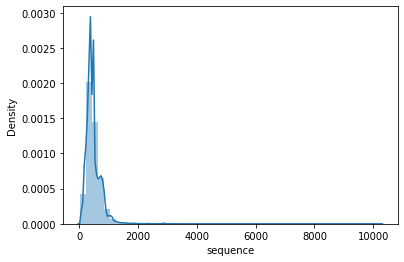

In [10]:
sns.distplot(df['sequence'].apply(lambda x: len(x)))

In [11]:
print("min length:", df['sequence'].apply(lambda x: len(x)).min())
print("max length:", df['sequence'].apply(lambda x: len(x)).max())
print("mean length:", round(df['sequence'].apply(lambda x: len(x)).mean()))
print("standard deviation: ", round(df['sequence'].apply(lambda x: len(x)).std()))
print("median length:", df['sequence'].apply(lambda x: len(x)).median())

min length: 10
max length: 10270
mean length: 470
standard deviation:  255
median length: 420.0


In [12]:
del identifiers, sequences, effects, s1, s2, s3, df_effect_count, find_index
gc.collect()

190

In [13]:
# df_train, df_val, df_test = np.split(df.sample(frac=1, random_state=21), [int(.6*len(df)), int(.8*len(df))])

df_train, df_remain_ = train_test_split(df, stratify=df['effect'], test_size=0.20, random_state=42)
df_val, df_test = train_test_split(df_remain_, stratify=df_remain_['effect'], test_size=0.50, random_state=42)

In [14]:
del df_remain_
gc.collect()

100

In [15]:
len(df_train), len(df_val), len(df_test)

(852948, 106618, 106619)

In [16]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 852948 entries, AMC89665.1 to EAZ35861.1
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   sequence  852948 non-null  object
 1   effect    852948 non-null  object
dtypes: object(2)
memory usage: 19.5+ MB


In [17]:
df_train.head(1)['sequence'].values[0]

'mkalrrftvrahlperlaaldqlstnlrwswdkptqdlfaaidpalweqcghdpvallgavnparldelaldaeflgaldelaadlndylsrplwyqeqqdagvaaqalptgiayfslefgvaevlpnysgglgilagdhlksasdlgvpliavglyyrsgyfrqsltadgwqhetypsldpqglplrlltdangdpvlvevalgdnavlrariwvaqvgrvplllldsdipenehdlrnvtdrlyggdqehrikqeilagiggvrairaytavekltppevfhmneghagflgierirelvtdagldfdtaltvvrsstvftthtpvpagidrfplemvqryvndqrgdgrsrllpglpadrivalgaeddpakfnmahmglrlaqrangvsllhgrvsramfnelwagfdpdevpigsvtngmhaptwaapqwlqlgrelagsdslrepvvwqrlhqvdpahlwwirsqlrsmlvedvrarlrqswlergatdaelgwiatafdpnvltvgfarrvptykrltlmlrdpdrleqllldeqrpiqlivagkshpaddggkaliqqvvrfadrpqvrhriaflpnydmsmarllywgcdvwlnnplrpleacgtsgmksalngglnlsirdgwwdewydgengweipsadgvadenrrddleagalydllaqavapkfyerdergvpqrwvemvrhtlqtlgpkvlasrmvrdyvehyyapaaqsfrrtagaqfdaareladyrrraeeawpkieiadvdstglpdtpllgsqltltatvrlaglrpndvtvqgvlgrvdagdvlmdpvtvemahtgtgdggyeifstttplplagpvgytvrvlprhpmlaasnelglvtla'

In [18]:
len(df_train.head(1)['sequence'].values[0])

863

In [19]:
df_train['seq_char_count']= df_train['sequence'].apply(lambda x: len(x))
df_val['seq_char_count']= df_val['sequence'].apply(lambda x: len(x))
df_test['seq_char_count']= df_test['sequence'].apply(lambda x: len(x))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [20]:
def plot_seq_count(df, data_name):
  sns.distplot(df['seq_char_count'].values)
  plt.title(f'Sequence char count: {data_name}')
  plt.grid(True)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

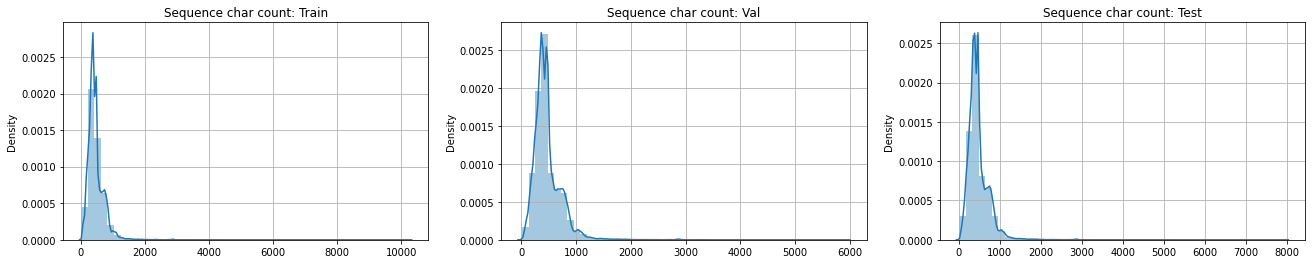

In [21]:
plt.subplot(1, 3, 1)
plot_seq_count(df_train, 'Train')

plt.subplot(1, 3, 2)
plot_seq_count(df_val, 'Val')

plt.subplot(1, 3, 3)
plot_seq_count(df_test, 'Test')

plt.subplots_adjust(right=3.0)
plt.show()

In [22]:
def get_code_freq(df, data_name):
  
  # df = df.apply(lambda x: " ".join(x))
  
  codes = []
  for i in df: # concatination of all codes
    codes.extend(i)

  del df; gc.collect()

  codes_dict= Counter(codes)
  del codes; gc.collect()

  # codes_dict.pop(' ') # removing white space
  
  print(f'Codes: {data_name}')
  print(f'Total unique codes: {len(codes_dict.keys())}')

  df = pd.DataFrame({'Code': list(codes_dict.keys()), 'Freq': list(codes_dict.values())})
  return df.sort_values('Freq', ascending=False).reset_index()[['Code', 'Freq']]

In [23]:
def plot_code_freq(df, data_name):
  
  plt.title(f'Code frequency: {data_name}')
  sns.barplot(x='Code', y='Freq', data=df)

Codes: Train
Total unique codes: 50
Codes: Val
Total unique codes: 49
Codes: Test
Total unique codes: 46


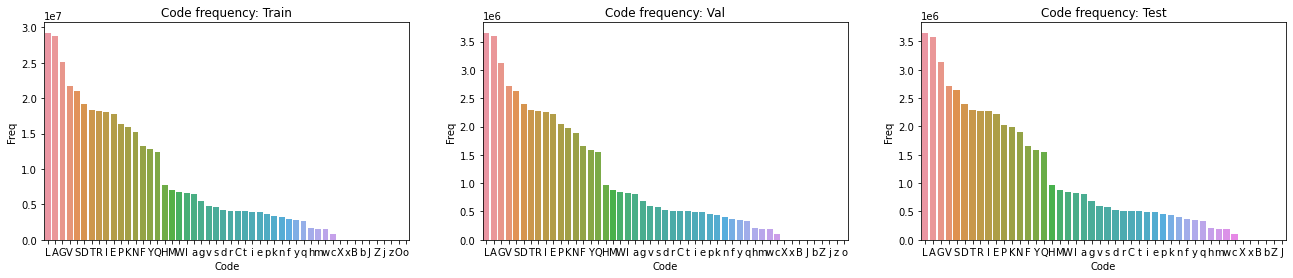

In [24]:
plt.subplot(1, 3, 1)
# train code sequence
train_code_freq = get_code_freq(df_train['sequence'], 'Train')
plot_code_freq(train_code_freq, 'Train')
del train_code_freq; gc.collect();

plt.subplot(1, 3, 2)
# val code sequence
val_code_freq = get_code_freq(df_val['sequence'], 'Val')
plot_code_freq(val_code_freq, 'Val')
del val_code_freq; gc.collect();

plt.subplot(1, 3, 3)
# test code sequence
test_code_freq = get_code_freq(df_test['sequence'], 'Test')
plot_code_freq(test_code_freq, 'Test')
del test_code_freq; gc.collect();

plt.subplots_adjust(right=3.0)
plt.show()

In [25]:
codes = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L',
         'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']

def create_dict(codes):
  char_dict = {}
  for index, val in enumerate(codes):
    char_dict[val] = index+1

  return char_dict

char_dict = create_dict(codes)

print(char_dict)
print("Dict Length:", len(char_dict))

{'A': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'K': 9, 'L': 10, 'M': 11, 'N': 12, 'P': 13, 'Q': 14, 'R': 15, 'S': 16, 'T': 17, 'V': 18, 'W': 19, 'Y': 20}
Dict Length: 20


In [26]:
def integer_encoding(data):
  """
  - Encodes code sequence to integer values.
  - 20 common amino acids are taken into consideration
    and rest 4 are categorized as 0.
  """
  
  encode_list = []
  for row in data['sequence'].values:
    row_encode = []
    for code in row:
      row_encode.append(char_dict.get(code, 0))
    encode_list.append(np.array(row_encode))
  
  return encode_list

In [27]:
train_encode = integer_encoding(df_train) 
val_encode = integer_encoding(df_val) 
test_encode = integer_encoding(df_test)

In [28]:
# padding sequences

max_length = 470
train_pad = pad_sequences(train_encode, maxlen=max_length, padding='post', truncating='post')
val_pad = pad_sequences(val_encode, maxlen=max_length, padding='post', truncating='post')
test_pad = pad_sequences(test_encode, maxlen=max_length, padding='post', truncating='post')

train_pad.shape, val_pad.shape, test_pad.shape

((852948, 470), (106618, 470), (106619, 470))

In [29]:
del train_encode, val_encode, test_encode
gc.collect()

34588

In [30]:
# # One hot encoding of sequences

# train_ohe = to_categorical(train_pad)
# val_ohe = to_categorical(val_pad)
# test_ohe = to_categorical(test_pad)

# train_ohe.shape, test_ohe.shape, test_ohe.shape

In [31]:
# del train_pad, val_pad, test_pad
# gc.collect()

In [32]:
# label/integer encoding output variable: (y)
le = LabelEncoder()

y_train_le = le.fit_transform(df_train['effect'])
y_val_le = le.transform(df_val['effect'])
y_test_le = le.transform(df_test['effect'])

y_train_le.shape, y_val_le.shape, y_test_le.shape

((852948,), (106618,), (106619,))

In [33]:
print('Total classes: ', len(le.classes_))
del le; gc.collect()
# le.classes_

Total classes:  562


202

In [34]:
# One hot encoding of outputs
y_train = to_categorical(y_train_le)
del y_train_le; gc.collect()
y_val = to_categorical(y_val_le)
del y_val_le; gc.collect()
y_test = to_categorical(y_test_le)
del y_test_le; gc.collect()

y_train.shape, y_val.shape, y_test.shape

((852948, 562), (106618, 562), (106619, 562))

In [35]:

# Utility function: plot model's accuracy and loss

# https://realpython.com/python-keras-text-classification/
plt.style.use('ggplot')

def plot_history(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  x = range(1, len(acc) + 1)

  plt.figure(figsize=(12, 5))
  plt.subplot(1, 2, 1)
  plt.plot(x, acc, 'b', label='Training acc')
  plt.plot(x, val_acc, 'r', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.legend()

  plt.subplot(1, 2, 2)
  plt.plot(x, loss, 'b', label='Training loss')
  plt.plot(x, val_loss, 'r', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()

In [36]:

# Utility function: Display model score(Loss & Accuracy) across all sets.

def display_model_score(model, train, val, test, batch_size):

  train_score = model.evaluate(train[0], train[1], batch_size=batch_size, verbose=1)
  print('Train loss: ', train_score[0])
  print('Train accuracy: ', train_score[1])
  print('-'*70)

  val_score = model.evaluate(val[0], val[1], batch_size=batch_size, verbose=1)
  print('Val loss: ', val_score[0])
  print('Val accuracy: ', val_score[1])
  print('-'*70)
  
  test_score = model.evaluate(test[0], test[1], batch_size=batch_size, verbose=1)
  print('Test loss: ', test_score[0])
  print('Test accuracy: ', test_score[1])

In [37]:
x_input = Input(shape=(470,))
emb = Embedding(21, 128, input_length=max_length)(x_input)
bi_rnn = Bidirectional(CuDNNLSTM(64, kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01), bias_regularizer=l2(0.01)))(emb)
x = Dropout(0.3)(bi_rnn)

# softmax classifier
x_output = Dense(562, activation='softmax')(x)

model1 = Model(inputs=x_input, outputs=x_output)
model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model1.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 470)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 470, 128)          2688      
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               99328     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 562)               72498     
Total params: 174,514
Trainable params: 174,514
Non-trainable params: 0
_________________________________________________________________


In [38]:
# Early Stopping
es = EarlyStopping(monitor='val_loss', patience=3, verbose=1)

In [ ]:
history1 = model1.fit(
    train_pad, y_train,
    epochs=50, batch_size=256,
    validation_data=(val_pad, y_val),
    callbacks=[es]
    )

Epoch 1/50
3332/3332 [==============================] - 322s 90ms/step - loss: 4.9314 - accuracy: 0.1854 - val_loss: 4.0149 - val_accuracy: 0.2277
Epoch 2/50
3332/3332 [==============================] - 298s 89ms/step - loss: 3.8705 - accuracy: 0.2480 - val_loss: 3.5341 - val_accuracy: 0.3126
Epoch 3/50
3332/3332 [==============================] - 297s 89ms/step - loss: 3.4073 - accuracy: 0.3347 - val_loss: 2.8847 - val_accuracy: 0.4389
Epoch 4/50
3332/3332 [==============================] - 296s 89ms/step - loss: 2.9267 - accuracy: 0.4266 - val_loss: 2.7239 - val_accuracy: 0.4710
Epoch 5/50
3332/3332 [==============================] - 296s 89ms/step - loss: 2.7243 - accuracy: 0.4681 - val_loss: 2.4238 - val_accuracy: 0.5365
Epoch 6/50
3332/3332 [==============================] - 296s 89ms/step - loss: 2.5406 - accuracy: 0.5077 - val_loss: 2.3081 - val_accuracy: 0.5577
Epoch 7/50
3332/3332 [==============================] - 296s 89ms/step - loss: 2.4258 - accuracy: 0.5328 - val_loss: 2

In [ ]:
# saving model weights.
model1.save('/content/drive/My Drive/ecami/output/bdlstm_model4.h5')

In [ ]:
plot_history(history1)

In [ ]:
display_model_score(model1,
    [train_pad, y_train],
    [val_pad, y_val],
    [test_pad, y_test],
    256)